# Train TFT with BTC USDT Data From Binance

In [1]:
import json 
import pandas as pd 
import numpy as np 
import time 
from datetime import timezone 
import os
from mplfinance.original_flavor import candlestick_ohlc
import pyupbit 
import ccxt
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from transformers import *
import os 
import time 
import datetime 
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np

/opt/conda/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Preprocess Data

In [2]:
btc_2019 = pd.read_csv("data_5m/2019_BTCUSDT.csv") 
btc_2020 = pd.read_csv("data_5m/2020_BTCUSDT.csv") 
btc_2021 = pd.read_csv("data_5m/2021_BTCUSDT.csv") 
btc_2022 = pd.read_csv("data_5m/2022_BTCUSDT.csv") 

btc_2019.shape, btc_2020.shape, btc_2021.shape, btc_2022.shape

((105291, 7), (105685, 7), (105448, 7), (10474, 7))

In [3]:
def process_datetime(df): 
    binance = ccxt.binance()
    dates = df['Open Time'].values 
    timestamp = [] 
    for i in range(len(dates)): 
        date_string = binance.iso8601(int(dates[i]))  
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp
    df['hours'] = df['datetime'].apply(lambda x : pd.to_datetime(x).hour)
    df = df.drop(columns={'0', 'Open Time'})
    return df

In [4]:
btc2019 = process_datetime(btc_2019)
btc2020 = process_datetime(btc_2020) 
btc2021 = process_datetime(btc_2021) 
btc2022 = process_datetime(btc_2022)

In [5]:
btc2019.shape, btc2020.shape, btc2021.shape, btc2022.shape

((105291, 7), (105685, 7), (105448, 7), (10474, 7))

Validation data dates up to 2022-02-06 04:25:00 
        
The test data can range from any time after this timestamp. 

In [6]:
train = pd.concat([btc2019, btc2020, btc2021]) 
val = btc2022 

In [7]:
con_cols = ['Open', 'High', 'Low', 'Close', 'Volume']  

norm = train.copy()   
train[con_cols] = (train[con_cols] - norm[con_cols].stack().mean()) / norm[con_cols].stack().std() 

In [8]:
train.head() 

,Open,High,Low,Close,Volume,datetime,hours
0,-0.723291,-0.723162,-0.723616,-0.723547,-0.911695,2019-01-01 00:00:00,0
1,-0.723548,-0.723499,-0.723883,-0.723755,-0.912908,2019-01-01 00:05:00,0
2,-0.723755,-0.723411,-0.723755,-0.723496,-0.913908,2019-01-01 00:10:00,0
3,-0.723464,-0.723421,-0.723720,-0.723720,-0.913624,2019-01-01 00:15:00,0
4,-0.723697,-0.723565,-0.723829,-0.723763,-0.913668,2019-01-01 00:20:00,0


In [9]:
past_seq_len = 80 
future_seq_len = 12 # predict the next hour, for every 5 minute intevals 

In [10]:
train_cont = train[['Open','High','Low','Close','Volume']].values 
train_disc = train[['hours']].values

val_cont = val[['Open', 'High', 'Low', 'Close', 'Volume']].values 
val_disc = val[['hours']].values 


train_in_cont, train_target_seq = [], []  
train_in_disc, train_future_disc = [], []  

for i in tqdm(range(train_cont.shape[0]-past_seq_len-future_seq_len+1), position=0, leave=True): 
    in_cont = train_cont[i:i+past_seq_len,:] 
    in_disc = train_disc[i:i+past_seq_len,:] 
    target = train_cont[i+past_seq_len:i+past_seq_len+future_seq_len,3] 
    future_disc = train_disc[i+past_seq_len:i+past_seq_len+future_seq_len,:] 
    
    train_in_cont.append(in_cont) 
    train_target_seq.append(target)
    train_in_disc.append(in_disc) 
    train_future_disc.append(future_disc) 


100%|██████████| 316333/316333 [00:00<00:00, 357492.45it/s]


In [11]:
train_in_cont = torch.tensor(train_in_cont, dtype=torch.float32)
train_target_seq = torch.tensor(train_target_seq, dtype=torch.float32)
train_in_disc = torch.tensor(train_in_disc, dtype=torch.float32)
train_future_disc = torch.tensor(train_future_disc, dtype=torch.float32) 

train_in_cont.shape, train_target_seq.shape, train_in_disc.shape, train_future_disc.shape

(torch.Size([316333, 80, 5]),
 torch.Size([316333, 12]),
 torch.Size([316333, 80, 1]),
 torch.Size([316333, 12, 1]))

In [12]:
train_in_cont = torch.reshape(train_in_cont, (-1, past_seq_len, 5, 1)) 
train_target_seq = torch.reshape(train_target_seq, (-1, future_seq_len, 1)) 


train_in_cont.shape, train_target_seq.shape

(torch.Size([316333, 80, 5, 1]), torch.Size([316333, 12, 1]))

In [13]:
def one_hot(x, dims, gpu = True):
    out = []
    batch_size = x.shape[0]
    seq_len = x.shape[1]
    
    if(not gpu):
        dtype = torch.FloatTensor
    else:
        dtype = torch.cuda.FloatTensor
        
    for i in range(0, x.shape[-1]):
        x_ = x[:,:,i].byte().cpu().long().unsqueeze(-1)
        o = torch.zeros([batch_size, seq_len, dims[i]]).long()

        o.scatter_(-1, x_,  1)
        out.append(o.type(dtype))
    return out

In [14]:
train_in_disc = one_hot(train_in_disc, dims=[24])  
train_in_disc = train_in_disc[0] 

train_future_disc = one_hot(train_future_disc, dims=[24]) 
train_future_disc = train_future_disc[0] 

train_in_disc.shape, train_future_disc.shape

(torch.Size([316333, 80, 24]), torch.Size([316333, 12, 24]))

In [15]:
train_in_disc = torch.reshape(train_in_disc, (-1, past_seq_len, 1, 24)) 
train_future_disc = torch.reshape(train_future_disc, (-1, future_seq_len, 1, 24)) 

train_in_disc.shape, train_future_disc.shape

(torch.Size([316333, 80, 1, 24]), torch.Size([316333, 12, 1, 24]))

In [16]:
train_in_cont.shape, train_target_seq.shape, train_in_disc.shape, train_future_disc.shape 

(torch.Size([316333, 80, 5, 1]),
 torch.Size([316333, 12, 1]),
 torch.Size([316333, 80, 1, 24]),
 torch.Size([316333, 12, 1, 24]))

In [17]:
val_in_cont, val_target_seq = [], []  
val_in_disc, val_future_disc = [], []  

for i in tqdm(range(val_cont.shape[0]-past_seq_len-future_seq_len+1), position=0, leave=True): 
    in_cont = val_cont[i:i+past_seq_len,:] 
    in_disc = val_disc[i:i+past_seq_len,:] 
    target = val_cont[i+past_seq_len:i+past_seq_len+future_seq_len,3] 
    future_disc = val_disc[i+past_seq_len:i+past_seq_len+future_seq_len,:] 
    
    val_in_cont.append(in_cont) 
    val_target_seq.append(target)
    val_in_disc.append(in_disc) 
    val_future_disc.append(future_disc) 


100%|██████████| 10383/10383 [00:00<00:00, 358579.32it/s]


In [18]:
val_in_cont = torch.tensor(val_in_cont) 
val_target_seq = torch.tensor(val_target_seq)
val_in_disc = torch.tensor(val_in_disc) 
val_future_disc = torch.tensor(val_future_disc) 

val_in_cont = torch.reshape(val_in_cont, (-1, past_seq_len, 5, 1)) 
val_target_seq = torch.reshape(val_target_seq, (-1, future_seq_len, 1)) 

val_in_disc = one_hot(val_in_disc, dims=[24]) 
val_in_disc = val_in_disc[0] 
val_in_disc = torch.reshape(val_in_disc, (-1, past_seq_len, 1, 24)) 

val_future_disc = one_hot(val_future_disc, dims=[24]) 
val_future_disc = val_future_disc[0] 
val_future_disc = torch.reshape(val_future_disc, (-1, future_seq_len, 1, 24)) 

val_in_cont.shape, val_target_seq.shape, val_in_disc.shape, val_future_disc.shape

(torch.Size([10383, 80, 5, 1]),
 torch.Size([10383, 12, 1]),
 torch.Size([10383, 80, 1, 24]),
 torch.Size([10383, 12, 1, 24]))

# Utility Functions 

Attention

In [19]:
def a_norm(Q, K): 
    m = torch.matmul(Q, K.transpose(2,1).float()) 
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float()) 
    return torch.softmax(m, -1) 

def attention(Q, K, V): 
    a = a_norm(Q, K) # (batch_size, dim_attn, seq_length) 
    return torch.matmul(a, V) # (batch_size, seq_length, seq_length) 

class AttentionBlock(torch.nn.Module): 
    def __init__(self, dim_val, dim_attn): 
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val) 
        self.key = Key(dim_val, dim_attn) 
        self.query = Query(dim_val, dim_attn) 
    
    def forward(self, x, kv = None):
        if kv is None:
            # Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        # Attention with x as Q, external vector kv as K and V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False).cuda()
    
    def forward(self, x):
        return self.fc1(x)

def QuantileLoss(net_out, Y, q):
    return (q * F.relu(net_out - Y)) + ((1 - q) * F.relu(Y - net_out))


# Gated Residual Network

Used for skipping over any unused components to efficiently build feature representations for each input type for high forecasting performance on a wide range of problems. 

In [20]:
class GLU(torch.nn.Module):
    def __init__(self, dim_input):
        super(GLU, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_input)
        self.fc2 = nn.Linear(dim_input, dim_input)
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x)) * self.fc2(x) 

In [21]:
class GRN(torch.nn.Module): 
    def __init__(self, dim_input, dim_out=None, n_hidden=10, dropout_r=0.1):
        super(GRN, self).__init__() 
        if dim_out != None: 
            self.skip = nn.Linear(dim_input, dim_out) 
        else:
            self.skip = None
            dim_out = dim_input 
        self.fc1 = nn.Linear(dim_input, n_hidden) 
        self.fc2 = nn.Linear(n_hidden, dim_out) 
        self.dropout = nn.Dropout(dropout_r) 
        self.gate = GLU(dim_out) 
        self.norm = nn.LayerNorm(dim_out) 
        
    def forward(self, x):
        a = F.elu(self.fc1(x))
        a = self.dropout(self.fc2(a))
        a = self.gate(a)
        if self.skip != None:
            return self.norm(self.skip(x) + a)
        return self.norm(x + a)

# Variable Selection Network 
Used for selecting relevant input variables at each time step

In [22]:
class VSN(torch.nn.Module): 
    def __init__(self, n_var_cont, n_var_disc, dim_model, dropout_r=0.1): 
        super(VSN, self).__init__()
        n_var_total = n_var_cont + len(n_var_disc)
        # linear transformation of inputs into dmodel vectors 
        self.linearise = []
        for i in range(n_var_cont): 
            self.linearise.append(nn.Linear(1, dim_model, bias=False).cuda()) 
        
        self.fc = nn.Linear(1, dim_model, bias=False).cuda()     
        # entity embeddings for discrete inputs 
        self.entity_embed = [] 
        for i in n_var_disc: 
            self.entity_embed.append(nn.Linear(i, dim_model, bias=False).cuda())  
        
        self.input_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.vs_grn = GRN(n_var_total * dim_model, dim_out=n_var_total, dropout_r = dropout_r)
    
    # input (batch_size, seq_len, n_variables, input_size)
    def forward(self, x_cont, x_disc): 
        # linearise continuous inputs 
        linearised = [] 
        for idx, fc in enumerate(self.linearise): 
            linearised.append(fc(x_cont[:,:,idx])) 
        # entity embeddings for discrete inputs 
        embedded = []
        for idx, fc in enumerate(self.entity_embed): 
            embedded.append(fc(x_disc[:,:,idx]))
        if len(self.linearise) != 0 and len(self.entity_embed) != 0: 
            linearised = torch.stack(linearised, dim=-2) 
            embedded = torch.stack(embedded, dim=-2)    
            vectorised_vars = torch.cat((linearised, embedded), dim=-2) # (batch_size, seq_len, dim_model, n_vars_total)
        elif len(self.linearise) != 0 and len(self.entity_embed) == 0: 
            vectorised_vars = torch.stack(linearised, dim=-2) # (batch_size, seq_len, n_var_cont, dim_model)
        elif len(self.entity_embed) != 0 and len(self.linearise) == 0: 
            vectorised_vars = torch.stack(embedded, dim=-2)
        
        # flatten everything except accross batch for variable selection weights 
        vs_weights = self.vs_grn(vectorised_vars.flatten(start_dim=2)) # (batch_size, seq_len, n_variables)
        vs_weights = torch.softmax(vs_weights, dim=-1).unsqueeze(-1) # (batch_size, seq_len, n_variables, 1) 
        
        # input_grn applied to every input separately 
        input_weights = self.input_grn(vectorised_vars) # (batch_size, seq_len, n_variables, dim_model)
        
        x = torch.sum((vs_weights * input_weights), dim = 2) 
        return x, vs_weights # returns (batch_size, seq_len, dim_model)
        

# LSTM Layer

In [23]:
class LSTMLayer(torch.nn.Module): 
    def __init__(self, dim_model, n_layers = 1, dropout_r = 0.1):
        super(LSTMLayer, self).__init__()
        self.n_layers = n_layers 
        self.dim_model = dim_model 
        self.lstm = nn.LSTM(dim_model, dim_model, num_layers = n_layers, batch_first = True) 
        self.hidden = None
        self.dropout = nn.Dropout(dropout_r) 
    
    # takes input (batch_size, seq_len, dim_model)
    def forward(self, x): 
        if self.hidden == None: 
            raise Exception("Call reset() to initialise LSTM Layer") 
            
        x, self.hidden = self.lstm(x, self.hidden) 
        x = self.dropout(x) 
        return x, self.hidden # returns (batch_size, seq_len, dim_model), hidden 
    
    def reset(self, batch_size, gpu = True): 
        if not gpu: 
            dtype = torch.FloatTensor 
        else: 
            dtype = torch.cuda.FloatTensor
        self.hidden = (torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype),
                       torch.zeros([self.n_layers, batch_size, self.dim_model]).type(dtype)) 

# TFT

In [24]:
class TFN(torch.nn.Module): 
    def __init__(self, 
                 n_var_past_cont, 
                 n_var_future_cont,
                 n_var_past_disc, 
                 n_var_future_disc,
                 dim_model,
                 n_quantiles = 3, 
                 dropout_r = 0.1,
                 n_lstm_layers = 1,
                 n_attention_layers = 1,
                 n_heads = 4):
        super(TFN, self).__init__()
        self.vs_past = VSN(n_var_past_cont, n_var_past_disc, dim_model, dropout_r = dropout_r) 
        self.vs_future = VSN(n_var_future_cont, n_var_future_disc, dim_model, dropout_r = dropout_r)
        
        self.enc = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        self.dec = LSTMLayer(dim_model, dropout_r = dropout_r, n_layers = n_lstm_layers) 
        
        self.gate1 = GLU(dim_model) 
        self.norm1 = nn.LayerNorm(dim_model) 
        
        self.static_enrich_grn = GRN(dim_model, dropout_r = dropout_r)
        
        self.attention = [] 
        for i in range(n_attention_layers): 
            self.attention.append([MultiHeadAttentionBlock(dim_model, dim_model, n_heads = n_heads).cuda(),
                                   nn.LayerNorm(dim_model).cuda()]) 
        
        self.norm2 = nn.LayerNorm(dim_model) 
        self.positionwise_grn = GRN(dim_model, dropout_r = dropout_r) 
        self.norm3 = nn.LayerNorm(dim_model) 
        self.dropout = nn.Dropout(dropout_r) 
        self.fc_out = nn.Linear(dim_model, n_quantiles) 
        
    # takes input (batch_size, past_seq_len, n_variables_past) 
    # and (batch_size, future_seq_len, n_variables_future) 
    def forward(self, x_past_cont, x_past_disc, x_future_cont, x_future_disc):
        # Encoder 
        x_past, vs_weights = self.vs_past(x_past_cont, x_past_disc) 
        e, e_hidden = self.enc(x_past) 
        self.dec_hidden = e_hidden 
        e = self.dropout(e) 
        x_past = self.norm1(self.gate1(e) + x_past) 

        # Decoder
        x_future, _ = self.vs_future(x_future_cont, x_future_disc) 
        d, _ = self.dec(x_future) 
        d = self.dropout(d) 
        x_future = self.norm1(self.gate1(d) + x_future) 

        # static enrichment
        x = torch.cat((x_past, x_future), dim=1) # (batch_size, past_seq_len + future_seq_len, dim_model)
        attention_res = x_future
        x = self.static_enrich_grn(x) 

        # attention layer 
        a = self.attention[0][1](self.attention[0][0](x) + x) 
        for at in self.attention[1:]:
            a = at[1](at[0](a) + a) 
        x_future = self.norm2(a[:, x_past.shape[1]:] + x_future) 
        a = self.positionwise_grn(x_future) 
        x_future = self.norm3(a + x_future + attention_res) 
        net_out = self.fc_out(x_future)  
        return net_out, vs_weights 

    def reset(self, batch_size, gpu = True): 
        self.enc.reset(batch_size, gpu) 
        self.dec.reset(batch_size, gpu) 

# Example Train

- train_in_cont.shape
- train_target_seq.shape
- train_in_disc.shape 
- train_future_disc.shape 

In [25]:
class CustomDataset(Dataset): 
    def __init__(self, past_cont, past_disc, target_seq, future_disc): 
        self.past_cont = past_cont
        self.past_disc = past_disc 
        self.target_seq = target_seq  
        self.future_disc = future_disc 
        
    def __len__(self): 
        return len(self.past_cont) 
    
    def __getitem__(self, i):  
        return {
            'past_cont': torch.tensor(self.past_cont[i], dtype=torch.float32), 
            'past_disc': torch.tensor(self.past_disc[i], dtype=torch.float32), 
            'target_seq': torch.tensor(self.target_seq[i], dtype=torch.float32),  
            'future_disc': torch.tensor(self.future_disc[i], dtype=torch.float32),  
        }

In [26]:
BATCH_SIZE = 128

train_dataset = CustomDataset(train_in_cont, train_in_disc, train_target_seq, train_future_disc)
val_dataset = CustomDataset(val_in_cont, val_in_disc, val_target_seq, val_future_disc)  

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True) 
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) 


In [27]:
model = TFN(n_var_past_cont = 5,
            n_var_future_cont = 0, 
            n_var_past_disc = [24],
            n_var_future_disc = [24],
            dim_model = 160) 

model.cuda()


TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=960, out_features=6, bias=True)
      (fc1): Linear(in_features=960, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=6, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=6, out_features=6, bias=True)
        (fc2): Linear(in_features=6, out_features=6, bias=True)
      )
      (norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)

In [28]:
device = torch.device('cuda')

quantiles = torch.tensor([0.1, 0.5, 0.9]).float().type(torch.cuda.FloatTensor)

epochs = 30 

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) 

train_losses, val_losses = [], [] 

In [29]:
def evaluate(data_dataloader): 
    eval_loss = 0 
    for step, batch in enumerate(data_dataloader): 
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device) 
        
        model.reset(batch_size=past_cont.shape[0], gpu=True)

        
        with torch.no_grad():
            net_out, vs_weights = model(x_past_cont = past_cont, 
                                        x_past_disc = past_disc,
                                        x_future_cont = None, 
                                        x_future_disc = future_disc) 
        
        loss = torch.mean(QuantileLoss(net_out, target_seq, quantiles)) 
        eval_loss += loss.item() 
    
    avg_val_loss = eval_loss / len(data_dataloader)
        
    return avg_val_loss, net_out, vs_weights


======== Epoch 1 / 30 ========
Training...


0it [00:00, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use s

saving best checkpoint


100it [00:34,  3.67it/s]

saving best checkpoint


150it [00:51,  3.53it/s]

saving best checkpoint


200it [01:09,  3.42it/s]

saving best checkpoint


250it [01:26,  3.60it/s]

saving best checkpoint


300it [01:44,  3.60it/s]

saving best checkpoint


500it [02:54,  3.56it/s]

saving best checkpoint


550it [03:10,  3.79it/s]

saving best checkpoint


600it [03:28,  3.67it/s]

saving best checkpoint


650it [03:45,  3.73it/s]

saving best checkpoint


700it [04:02,  3.69it/s]

saving best checkpoint


750it [04:20,  3.47it/s]

saving best checkpoint


800it [04:37,  3.46it/s]

saving best checkpoint


850it [04:54,  3.70it/s]

saving best checkpoint


900it [05:11,  3.70it/s]

saving best checkpoint


1000it [05:45,  3.64it/s]

saving best checkpoint


1050it [06:02,  3.69it/s]

saving best checkpoint


1100it [06:20,  3.52it/s]

saving best checkpoint


1200it [06:54,  3.68it/s]

saving best checkpoint


1250it [07:11,  3.66it/s]

saving best checkpoint


1550it [08:53,  3.53it/s]

saving best checkpoint


2472it [14:11,  2.90it/s]



======== Epoch 2 / 30 ========
Training...


2023it [11:43,  3.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2350it [13:18,  3.63it/s]

saving best checkpoint


2450it [13:52,  3.65it/s]

saving best checkpoint


2472it [14:02,  2.93it/s]



======== Epoch 4 / 30 ========
Training...


100it [00:31,  3.50it/s]

saving best checkpoint


350it [01:58,  3.55it/s]

saving best checkpoint


500it [02:52,  3.28it/s]

saving best checkpoint


1000it [05:50,  3.65it/s]

saving best checkpoint


1400it [08:07,  3.59it/s]

saving best checkpoint


1700it [09:49,  3.57it/s]

saving best checkpoint


1750it [10:06,  3.56it/s]

saving best checkpoint


1800it [10:23,  3.40it/s]

saving best checkpoint


2050it [11:47,  3.62it/s]

saving best checkpoint


2472it [14:15,  2.89it/s]



======== Epoch 5 / 30 ========
Training...


550it [03:06,  3.67it/s]

saving best checkpoint


600it [03:23,  3.73it/s]

saving best checkpoint


2472it [14:08,  2.91it/s]



======== Epoch 6 / 30 ========
Training...


300it [01:42,  3.56it/s]

saving best checkpoint


350it [02:00,  3.33it/s]

saving best checkpoint


2472it [14:15,  2.89it/s]



======== Epoch 7 / 30 ========
Training...


2472it [14:23,  2.86it/s]



======== Epoch 8 / 30 ========
Training...


2472it [14:34,  2.83it/s]



======== Epoch 9 / 30 ========
Training...


300it [01:44,  3.49it/s]

saving best checkpoint


2472it [14:13,  2.90it/s]



======== Epoch 10 / 30 ========
Training...


2472it [13:50,  2.97it/s]



======== Epoch 11 / 30 ========
Training...


50it [00:14,  3.55it/s]

saving best checkpoint


100it [00:31,  3.55it/s]

saving best checkpoint


250it [01:22,  3.15it/s]

saving best checkpoint


2472it [14:07,  2.92it/s]



======== Epoch 12 / 30 ========
Training...


2472it [14:05,  2.92it/s]



======== Epoch 13 / 30 ========
Training...


2472it [14:23,  2.86it/s]



======== Epoch 14 / 30 ========
Training...


2472it [14:25,  2.86it/s]



======== Epoch 15 / 30 ========
Training...


2472it [14:31,  2.84it/s]



======== Epoch 16 / 30 ========
Training...


2472it [14:35,  2.82it/s]



======== Epoch 17 / 30 ========
Training...


2472it [14:32,  2.83it/s]



======== Epoch 18 / 30 ========
Training...


2472it [13:59,  2.94it/s]



======== Epoch 19 / 30 ========
Training...


2472it [14:00,  2.94it/s]



======== Epoch 20 / 30 ========
Training...


2472it [14:15,  2.89it/s]



======== Epoch 21 / 30 ========
Training...


2472it [14:23,  2.86it/s]



======== Epoch 22 / 30 ========
Training...


2472it [14:28,  2.85it/s]



======== Epoch 23 / 30 ========
Training...


2472it [14:12,  2.90it/s]



======== Epoch 24 / 30 ========
Training...


2472it [14:23,  2.86it/s]



======== Epoch 25 / 30 ========
Training...


2472it [14:30,  2.84it/s]



======== Epoch 26 / 30 ========
Training...


2472it [14:28,  2.85it/s]



======== Epoch 27 / 30 ========
Training...


2472it [14:34,  2.83it/s]



======== Epoch 28 / 30 ========
Training...


2472it [14:48,  2.78it/s]



======== Epoch 29 / 30 ========
Training...


2472it [14:46,  2.79it/s]



======== Epoch 30 / 30 ========
Training...


2472it [14:53,  2.77it/s]


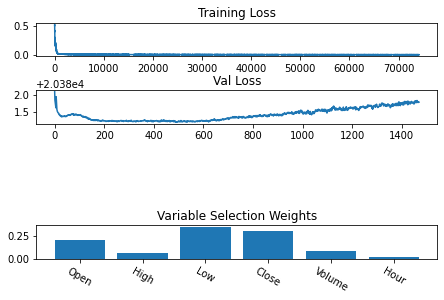

In [30]:
# plot figures every epoch 
fig = plt.figure()
ax = fig.add_subplot(411)
ax1 = fig.add_subplot(412)
# ax2 = fig.add_subplot(413)
ax3 = fig.add_subplot(414)
plt.ion()


for i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))
    print('Training...')
    total_loss = 0 
    model.train() 
    
    for step, batch in tqdm(enumerate(train_dataloader)): 
        if step%50 == 0 and not step == 0: 
            model.eval() 
            val_loss, _, _ = evaluate(val_dataloader) 
            val_losses.append(val_loss) 
            if np.min(val_losses) == val_losses[-1]: 
                print("saving best checkpoint") 
                torch.save(model.state_dict(), "TFT_test.pt") 
            model.train()  
    
        
        past_cont = batch['past_cont'].to(device) 
        past_disc = batch['past_disc'].to(device) 
        target_seq = batch['target_seq'].to(device) 
        future_disc = batch['future_disc'].to(device) 
        model.reset(batch_size=past_cont.shape[0], gpu=True)
                
        optimizer.zero_grad() 

        net_out, vs_weights = model(x_past_cont = past_cont, 
                                    x_past_disc = past_disc, 
                                    x_future_cont = None, 
                                    x_future_disc = future_disc) 
        
        # net_out = net_out.cpu().detach()[0]
        
        loss = torch.mean(QuantileLoss(net_out, target_seq, quantiles))  
        # backward pass 
        train_losses.append(loss.item()) 
        loss.backward() 
        optimizer.step() 

        # loss graphs
        fig.tight_layout(pad=0.1) 
        ax.clear()
        ax.title.set_text("Training Loss")
        ax.plot(train_losses)
        
        ax1.clear() 
        ax1.title.set_text("Val Loss")
        ax1.plot(val_losses) 
        
        # visualise variable selection weights 
        vs_weights = torch.mean(torch.mean(vs_weights, dim=0), dim=0).squeeze()  
        vs_weights = vs_weights.cpu().detach().numpy()
        ax3.clear() 
        ax3.title.set_text("Variable Selection Weights") 
        plt.xticks(rotation=-30) 
        x = ["Open", "High", "Low", "Close", "Volume", "Hour"] 
        ax3.bar(x=x, height=vs_weights) 
        fig.canvas.draw() 

In [68]:
model

TFN(
  (vs_past): VSN(
    (fc): Linear(in_features=1, out_features=160, bias=False)
    (input_grn): GRN(
      (fc1): Linear(in_features=160, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=160, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=160, out_features=160, bias=True)
        (fc2): Linear(in_features=160, out_features=160, bias=True)
      )
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (vs_grn): GRN(
      (skip): Linear(in_features=960, out_features=6, bias=True)
      (fc1): Linear(in_features=960, out_features=10, bias=True)
      (fc2): Linear(in_features=10, out_features=6, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (gate): GLU(
        (fc1): Linear(in_features=6, out_features=6, bias=True)
        (fc2): Linear(in_features=6, out_features=6, bias=True)
      )
      (norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)

# Prediction

In [60]:
mu = norm[con_cols].stack().mean()  
std = norm[con_cols].stack().std()

sample_in_cont = val_in_cont[0] 
sample_target_seq = val_target_seq[0] 
sample_in_disc = val_in_disc[0] 
sample_future_disc = val_future_disc[0] 


sample_in_cont = (sample_in_cont - mu) / std
sample_target_seq = (sample_target_seq - mu) / std  


sample_in_cont = torch.tensor(sample_in_cont, dtype=torch.float32)
sample_target_seq = torch.tensor(sample_target_seq, dtype=torch.float32) 
sample_in_disc = torch.tensor(sample_in_disc, dtype=torch.float32) 
sample_future_disc = torch.tensor(sample_future_disc, dtype=torch.float32)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTen

In [64]:
val_future_disc.shape

torch.Size([10383, 12, 1, 24])

In [61]:
sample_in_cont = torch.reshape(sample_in_cont, (-1,80,5,1)) 
sample_target_seq = torch.reshape(sample_target_seq, (-1,12,1)) 
sample_in_disc = torch.reshape(sample_in_disc, (-1, 80, 1, 24)) 
sample_future_disc = torch.reshape(sample_future_disc, (-1,12,1,24)) 

In [62]:
sample_in_cont = sample_in_cont.to(device) 
sample_target_seq = sample_target_seq.to(device) 
sample_in_disc = sample_in_disc.to(device) 
sample_future_disc = sample_future_disc.to(device) 


In [66]:
outputs=model(x_past_cont = sample_in_cont, 
               x_past_disc = sample_in_disc, 
               x_future_cont = None, 
               x_future_disc = sample_future_disc) 
              
outputs[0].shape

RuntimeError: Expected hidden[0] size (1, 1, 160), got [1, 45, 160]

In [71]:
outputs = model(x_past_cont = past_cont, 
      x_past_disc = past_disc,
      x_future_cont = None, 
      x_future_disc = future_disc) 

In [72]:
pred_seqs = outputs[0]

In [82]:
past_cont.shape

torch.Size([45, 80, 5, 1])

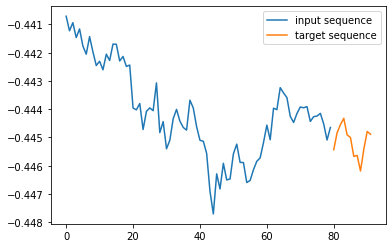

In [84]:
plt.plot(past_cont[0,:,3,:].detach().cpu(), label="input sequence")
plt.plot(np.arange(past_cont.shape[1], past_cont.shape[1]+target_seq.shape[1]),target_seq[0,:,:].detach().cpu(), label="target sequence")
plt.legend()

In [100]:
sample_in = torch.clone(past_cont)
sample_target = torch.clone(target_seq)  
sample_pred = torch.clone(pred_seqs) 

In [101]:
sample_in = sample_in.detach().cpu().numpy()  
sample_in = sample_in[0,:,3,:] 

sample_target = sample_target.detach().cpu().numpy() 
sample_target = sample_target[0,:,:] 


In [103]:
if sample_in[-1] > sample_target[0]: 
    diff = sample_in[-1] - sample_target[0] 
    sample_target += diff 
elif sample_in[-1] < sample_target[0]: 
    diff = sample_target[0] - sample_in[-1] 
    sample_target -= diff

In [117]:
if sample_in[-1] > sample_pred[0,1]: 
    diff = sample_in[-1] - sample_pred[0,1] 
    sample_pred[:,1] += diff 
elif sample_in[-1] < sample_pred[0,1]: 
    diff = sample_pred[0,1] - sample_in[-1] 
    sample_pred[:,1] -= diff

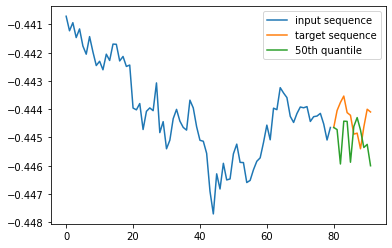

In [118]:
plt.plot(sample_in, label="input sequence")
plt.plot(np.arange(len(sample_in), len(sample_in)+len(sample_target)),sample_target, label="target sequence")
plt.plot(np.arange(len(sample_in), len(sample_in)+(sample_pred.shape[0])),sample_pred[:,1], label="50th quantile")
plt.legend()

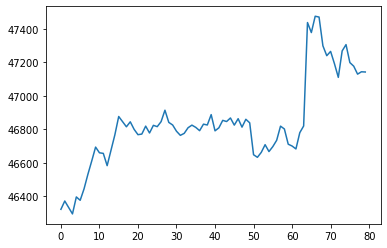

In [123]:
plt.plot(val_in_cont[0,:,3,:])